In [ ]:
%%script false
%cd /content/drive/MyDrive/Google Colab/NLP/Technometrics
%ls

/content/drive/MyDrive/Google Colab/NLP/Technometrics
Bi-LSTM_Train.ipynb        file_hist.json
Bi-LSTM_Ult.ipynb          Predict_Text.ipynb
Classification_Algo.ipynb  Pretrained_Models/
Dataset/                   Process_Data/
External.ipynb             Saved_Model/
file_hist_2.json           Technometrics_Preprocessing.ipynb


In [ ]:
import pandas as pd
import numpy as np
from statistics import mean, mode, median
import re
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)

from gensim.models import FastText
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import scale, MinMaxScaler
from tensorflow.keras.utils import to_categorical 

from sklearn.metrics import accuracy_score, log_loss, average_precision_score, f1_score, plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

In [ ]:
%ls Process_Data

test_category.npy       test_data_stop_raw.csv   train_data_stop.csv
test_cleanText.npy      train_category.npy       train_data_stop_raw.csv
test_data_stop_350.csv  train_cleanText.npy
test_data_stop.csv      train_data_stop_350.csv


In [ ]:
train_data = pd.read_csv('Process_Data/train_data_stop_raw.csv')
test_data  = pd.read_csv('Process_Data/test_data_stop_raw.csv')
train_data.head()

,category,text,cleanText
0,economy,বাংলাদেশে সফররত বিশ্ব বাণিজ্য সংস্থা (ডব্লিউট...,বাংলাদেশে সফররত বিশ্ব বাণিজ্য সংস্থা ডব্লিউটিও...
1,sports,ইউরোপিয়ান ফুটবলে আজ ঝড় বয়ে যাচ্ছে। একদিকে সংবা...,ইউরোপিয়ান ফুটবলে বয়ে একদিকে সংবাদমাধ্যমগুলো নে...
2,international,বিজেপির নেতৃত্বে ভারতের উত্তর প্রদেশ থেকে শুরু...,বিজেপির নেতৃত্বে ভারতের উত্তর প্রদেশ শুরু বিভি...
3,state,নারায়ণগঞ্জের সোনারগাঁ উপজেলার একটি সরকারি প্র...,নারায়ণগঞ্জের সোনারগাঁ উপজেলার সরকারি প্রাথমিক...
4,sports,"‘ছাই থেকে ছাই, ধুলো থেকে ধুলো...’ আধ্যাত্মিক ক...",ছাই ছাই ধুলো ধুলো আধ্যাত্মিক ব্যবহৃত বাক্যের অ...


In [ ]:
test_data.head()

,category,text,cleanText
0,education,"অধ্যায়-২প্রিয় পরীক্ষার্থী, আজ তথ্য ও যোগাযোগ প...",অধ্যায় প্রিয় পরীক্ষার্থী তথ্য যোগাযোগ প্রযুক্ত...
1,sports,"স্পিন, স্পিন, স্পিন। লর্ডসে ইয়াসির শাহ্‌র লেগ ...",স্পিন স্পিন স্পিন লর্ডসে ইয়াসির শাহ্ র লেগ স্প...
2,international,সিরিয়ার উত্তর-পশ্চিমাঞ্চলে গতকাল রোববার বিমান...,সিরিয়ার উত্তর পশ্চিমাঞ্চলে গতকাল রোববার বিমান...
3,international,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যালয়ের (ইউসিট...,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যালয়ের ইউসিটি...
4,technology,সহজে ডিজিটাল আর্থিক সেবা দিতে অ্যাপ ও ডিজিটাল ...,সহজে ডিজিটাল আর্থিক সেবা অ্যাপ ডিজিটাল কেওয়াইস...


# Feature Engineering

In [ ]:
column_names = ['cleanText', 'category']

train_data_full = pd.DataFrame(columns = column_names)

cnt = 0
j = 0
cleanText = []
category = []

for i in train_data['cleanText'].apply(lambda x: len(x.split(' '))):

  if i < 350:
    cleanText.append(train_data['cleanText'][j])
    category.append(train_data['category'][j])     
    cnt +=1

  j += 1
  
train_data_full['cleanText'] = cleanText
train_data_full['category'] = category

categor = cleanText = 0

print('Total Row length less then 351 : ',cnt)

Total Row length less then 351 :  90118


In [ ]:
column_names = ['cleanText', 'category']

test_data_full = pd.DataFrame(columns = column_names)

cnt = 0
j = 0
cleanText = []
category = []

for i in test_data['cleanText'].apply(lambda x: len(x.split(' '))):

  if i < 350:
    cleanText.append(test_data['cleanText'][j])
    category.append(test_data['category'][j])     
    cnt +=1

  j += 1
  
test_data_full['cleanText'] = cleanText
test_data_full['category'] = category

categor = cleanText = 0

print('Total Row length less then 351 : ',cnt)

Total Row length less then 351 :  90233


In [ ]:
train_data_full.head()

,cleanText,category
0,বাংলাদেশে সফররত বিশ্ব বাণিজ্য সংস্থা ডব্লিউটিও...,economy
1,ইউরোপিয়ান ফুটবলে বয়ে একদিকে সংবাদমাধ্যমগুলো নে...,sports
2,বিজেপির নেতৃত্বে ভারতের উত্তর প্রদেশ শুরু বিভি...,international
3,নারায়ণগঞ্জের সোনারগাঁ উপজেলার সরকারি প্রাথমিক...,state
4,ছাই ছাই ধুলো ধুলো আধ্যাত্মিক ব্যবহৃত বাক্যের অ...,sports


In [ ]:
len(train_data_full)

90118

In [ ]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm

# Feature Convertion

## Tf-Idf Conversion of X

In [ ]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(train_data_full['cleanText'])

xtrain_tfidf = tfidf_vect.transform(train_data_full['cleanText'])
xvalid_tfidf = tfidf_vect.transform(test_data_full['cleanText'])

## Labelencode Conversion of Y

In [ ]:
encoder = preprocessing.LabelEncoder()

train_y = encoder.fit_transform(train_data_full['category'])
valid_y = encoder.fit_transform(test_data_full['category'])

In [ ]:
print('=============================================')
print('                Train Data')
print('=============================================')
print('Shape of Train Text     : ',np.shape(xtrain_tfidf))
print('Shape of Train Category : ',np.shape(train_y))
print('=============================================')
print('                Test Data')
print('=============================================')
print('Shape of Test Text      : ',np.shape(xvalid_tfidf))
print('Shape of Test Category  : ',np.shape(valid_y))

print('=============================================')

                Train Data
Shape of Train Text     :  (90118, 5000)
Shape of Train Category :  (90118,)
                Test Data
Shape of Test Text      :  (90233, 5000)
Shape of Test Category  :  (90233,)


# Train Function Pipeline

In [ ]:
def train_model(classifier, feature_vector_train, label,feature_vector_valid, y_valid, is_neural_net=False):
  clf_name = classifier.__class__.__name__
  classifier.fit(feature_vector_train, label)
  predictions = classifier.predict(feature_vector_valid)

  try:
    y_pred_decision_tree = classifier.predict_proba(feature_vector_valid)
    loss = log_loss(y_valid, y_pred_decision_tree)
  except:
    predict_proba_dist = classifier.decision_function(feature_vector_valid)
    def softmax(x):
      e_x = np.exp(x - np.max(x))
      return e_x / e_x.sum(axis=0)

    y_pred_decision_tree = []
    for eachArr in predict_proba_dist:
        y_pred_decision_tree.append(softmax(eachArr))

    loss = log_loss(y_valid, y_pred_decision_tree)

  try:
    precision, recall, fscore, support = score(y_valid, predictions)
  except:
    print('Performance matrix not provided')

  acc = metrics.accuracy_score(predictions, y_valid)
  print('{:<25}'.format(str(clf_name)),": ", " Accuracy: {:.2%}".format(acc)," Loss: {:.2%}".format(loss))

  filename = 'Saved_Model/'+str(clf_name)+'_model.pkl'
  pickle.dump(classifier, open(filename, 'wb'))
  print('Model Saved ... ')

  #return clf_name, acc, loss
  return clf_name, acc, loss, precision, recall, fscore, support

  

# Start Training

In [ ]:
classifiers_stack = [
                     naive_bayes.MultinomialNB(alpha=0.2),
                     linear_model.LogisticRegression(),
                     LinearSVC(),
                     DecisionTreeClassifier(),
                     KNeighborsClassifier(),
]

acc_loss = pd.DataFrame(columns=["Classifier", "Accuracy", "Log Loss"])
column_for_matrix = ["Classifier","Matrix_Name", "economy", "education", "entertainment", "international", "sports","state", "technology"]
performance_matrix = pd.DataFrame(columns=column_for_matrix)

for classifier in classifiers_stack:

  clf_name, acc, loss, precision, recall, fscore, support = train_model(classifier,xtrain_tfidf, train_y, xvalid_tfidf, valid_y)

  temp = pd.DataFrame([[clf_name, "F1_Score", fscore[0],fscore[1],fscore[2],fscore[3],fscore[4],fscore[5],fscore[6]]], columns=column_for_matrix)
  print(temp)
  performance_matrix = performance_matrix.append(temp)

  temp = pd.DataFrame([[clf_name, "Precession", precision[0],precision[1],precision[2],precision[3],precision[4],precision[5],precision[6]]], columns=column_for_matrix)
  performance_matrix = performance_matrix.append(temp)

  temp = pd.DataFrame([[clf_name, "Recall", recall[0],recall[1],recall[2],recall[3],recall[4],recall[5],recall[6]]], columns=column_for_matrix)
  performance_matrix = performance_matrix.append(temp)

  temp = pd.DataFrame([[clf_name, acc*100, loss]], columns=["Classifier", "Accuracy", "Log Loss"])
  acc_loss = acc_loss.append(temp)


MultinomialNB             :   Accuracy: 87.17%  Loss: 65.97%
Model Saved ... 
      Classifier Matrix_Name   economy  ...    sports     state  technology
0  MultinomialNB    F1_Score  0.841909  ...  0.951626  0.827203    0.825391

[1 rows x 9 columns]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression        :   Accuracy: 89.54%  Loss: 35.47%
Model Saved ... 
           Classifier Matrix_Name   economy  ...    sports     state  technology
0  LogisticRegression    F1_Score  0.867301  ...  0.958553  0.859118    0.853629

[1 rows x 9 columns]
LinearSVC                 :   Accuracy: 90.89%  Loss: 56.39%
Model Saved ... 
  Classifier Matrix_Name  economy  ...    sports    state  technology
0  LinearSVC    F1_Score     0.88  ...  0.968211  0.87322    0.868059

[1 rows x 9 columns]
DecisionTreeClassifier    :   Accuracy: 69.47%  Loss: 1054.32%
Model Saved ... 
               Classifier Matrix_Name   economy  ...    sports     state  technology
0  DecisionTreeClassifier    F1_Score  0.625189  ...  0.812182  0.655206    0.613075

[1 rows x 9 columns]
KNeighborsClassifier      :   Accuracy: 83.92%  Loss: 201.83%
Model Saved ... 
             Classifier Matrix_Name   economy  ...    sports     state  technology
0  KNeighborsClassifier    F1_Score  0.829711  ...  0.910247  0.

In [ ]:
performance_matrix.head()

,Classifier,Matrix_Name,economy,education,entertainment,international,sports,state,technology
0,MultinomialNB,F1_Score,0.841909,0.842396,0.904339,0.877903,0.951626,0.827203,0.825391
0,MultinomialNB,Precession,0.838678,0.900550,0.885641,0.841154,0.961699,0.808544,0.875030
0,MultinomialNB,Recall,0.845164,0.791297,0.923844,0.918010,0.941762,0.846743,0.781082
0,LogisticRegression,F1_Score,0.867301,0.886915,0.921102,0.898121,0.958553,0.859118,0.853629
0,LogisticRegression,Precession,0.865753,0.887149,0.917061,0.883452,0.961380,0.868995,0.865402


#Performance Score saveing

In [ ]:
acc_loss.to_csv('Classifier_Accuracy_Loss.csv', encoding='utf-8', index=False) 
performance_matrix.to_csv('Classifier_Performance_Matrix.csv', encoding='utf-8', index=False) 

#Plot of Model accuracy

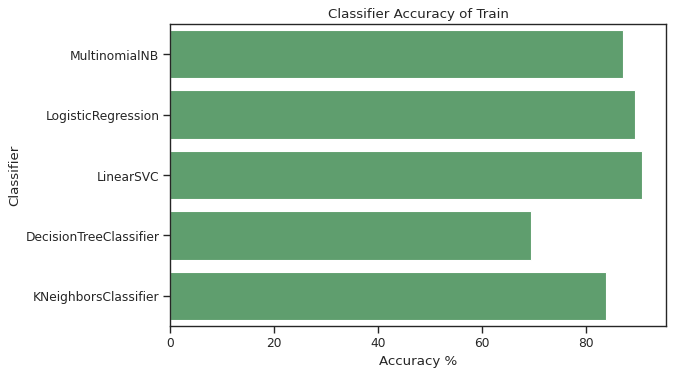

In [ ]:
plt.figure(figsize=(8,5), dpi= 80)
sns.barplot(x='Accuracy', y='Classifier', data=acc_loss, color="g")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy of Train')
plt.show()